In [1]:
import os
import random
import numpy as np
import time

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
NUM_POINTS = 50
gestures = set()

## Splitting files in train and test 

Get filenames of all gesture templates

In [3]:
data_filenames = []

for subject_dir in os.listdir(f'dataset'):
    if 'pilot' not in subject_dir and 'README' not in subject_dir:
        for velo_dir in os.listdir(f'dataset/{subject_dir}'):
            for filename in os.listdir(f'dataset/{subject_dir}/{velo_dir}'):
                if 'ipynb' not in filename:
                    gestures.add(filename[:-6])
                    path = os.path.normpath(f'dataset/{subject_dir}/{velo_dir}/{filename}')
                    data_filenames.append(path)


Define test and train data by selecting 10 files for each gesture randomly.
The remaining files will be the train data.

In [4]:
random.shuffle(data_filenames)
test_filenames = []
train_filenames = []
for gesture in gestures:
    gest_filenames = [filename for filename in data_filenames if gesture == filename.split('/')[3][:-6]]
    test_filenames.extend(gest_filenames[:10])
    train_filenames.extend(gest_filenames[10:])


## Read and preprocess train and test data

In [5]:
data_test = []
for filename in test_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_test.append((label, resampled))

In [6]:
data_train = []
for filename in train_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_train.append((label, resampled))

In [7]:
labels_test = [sample[0] for sample in data_test]
labels_train = [sample[0] for sample in data_train]

encoder_test = LabelEncoder()
labels_test_encoded = encoder_test.fit_transform(labels_test)
y_test = to_categorical(labels_test_encoded)

encoder_train = LabelEncoder()
labels_train_encoded = encoder_train.fit_transform(labels_train)
y_train = to_categorical(labels_train_encoded)

sequences_test = [sample[1] for sample in data_test]
sequences_train = [sample[1] for sample in data_train]

X_test = np.array(sequences_test)
X_train = np.array(sequences_train)

## Builung the model

In [8]:
def build_model(lstm_units):
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(lstm_units, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(gestures), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


## Fit the model and display results

In [9]:
def fit_model(model):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    start = time.time()
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early],
    )
    duartion = time.time() - start
    return history, duartion

In [10]:
def display_summary(model):
    model.summary()

In [11]:
def display_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [12]:
def predict_and_display_conf_matrix(model):
    start = time.time()
    y_predictions = model.predict(X_test)
    duration = time.time() - start

    y_predictions = np.argmax(y_predictions, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))
    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_test)).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha='center')
    pass
    return duration

In [13]:
y_test.shape, y_train.shape

((160, 16), (5120, 16))

# Comparing Gesture Recognizers
In the following, there is a comparison between LSTM gesture recignizers.
They differ in their number of units in LSTM Layer to reduce LSTM's parameter count.
- 128 units
- 64 units
- 32 units
- 16 units

Eventually, these recognizers are compared to Wobbrock's $1 Gesture Recognizer.


## Condition 1 - 128 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 9s 44ms/step - loss: 0.8833 - accuracy: 0.7295 - val_loss: 0.2822 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 7s 41ms/step - loss: 0.1532 - accuracy: 0.9520 - val_loss: 0.0869 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 8s 52ms/step - loss: 0.0720 - accuracy: 0.9805 - val_loss: 0.0723 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 7s 44ms/step - loss: 0.0690 - accuracy: 0.9816 - val_loss: 0.0435 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 7s 42ms/step - loss: 0.0540 - accuracy: 0.9861 - val_loss: 0.0543 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 7s 42ms/step - loss: 0.0443 - accuracy: 0.9893 - val_loss: 0.0559 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 7s 43ms/st

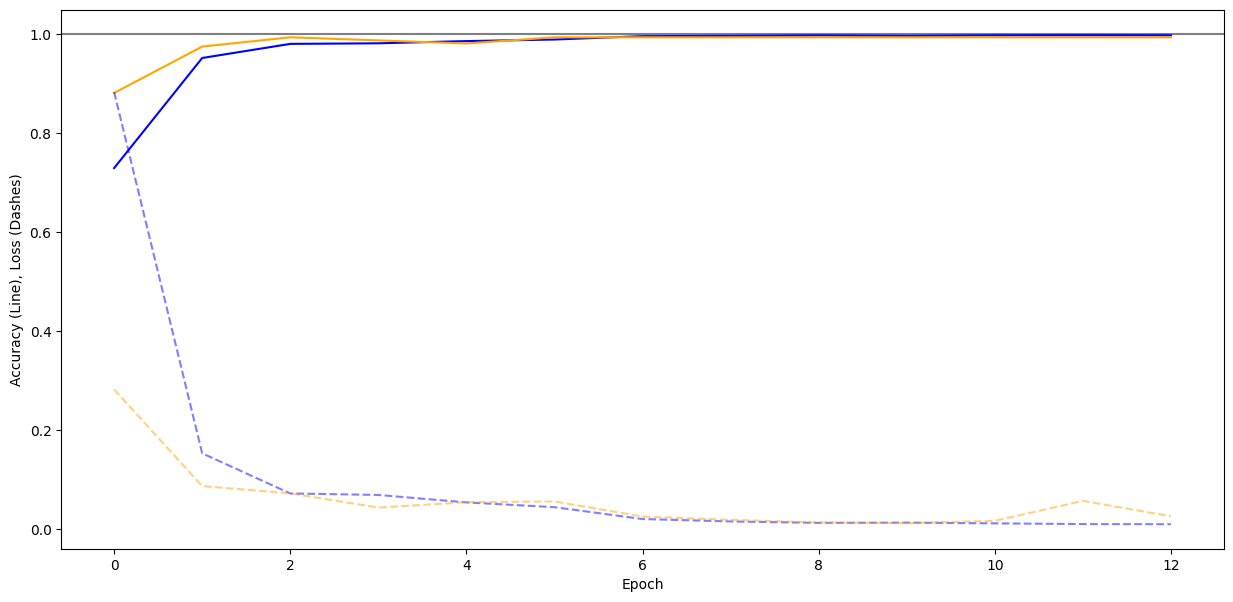

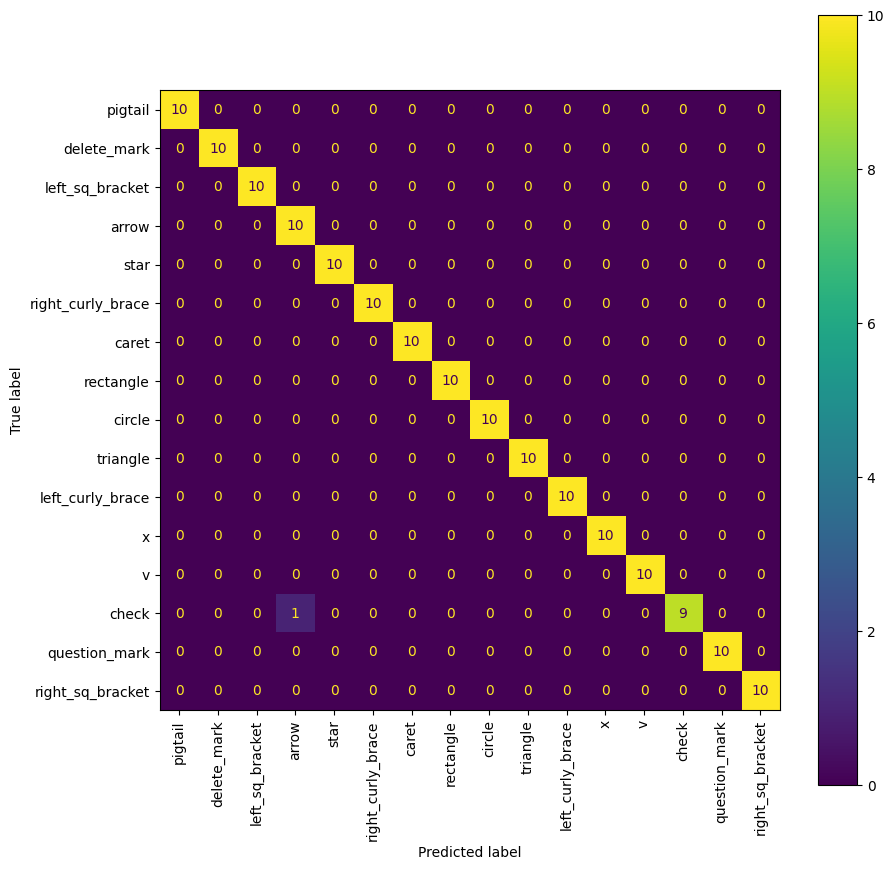

In [14]:
UNITS_LSTM = 128

model_cond1 = build_model(UNITS_LSTM)
history_cond1, duration_train_cond1 = fit_model(model_cond1)
display_summary(model_cond1)
display_results(history_cond1)
duration_predict_cond1 = predict_and_display_conf_matrix(model_cond1)
acc_cond1 = history_cond1.history['val_accuracy']

## Condition 2 - 64 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 6s 27ms/step - loss: 1.2155 - accuracy: 0.6715 - val_loss: 0.2040 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 4s 26ms/step - loss: 0.1641 - accuracy: 0.9613 - val_loss: 0.0899 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 5s 31ms/step - loss: 0.0954 - accuracy: 0.9752 - val_loss: 0.0281 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 4s 27ms/step - loss: 0.0529 - accuracy: 0.9885 - val_loss: 0.0227 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 4s 22ms/step - loss: 0.0471 - accuracy: 0.9879 - val_loss: 0.0552 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 4s 22ms/step - loss: 0.0589 - accuracy: 0.9836 - val_loss: 0.0479 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 4s 23ms/st

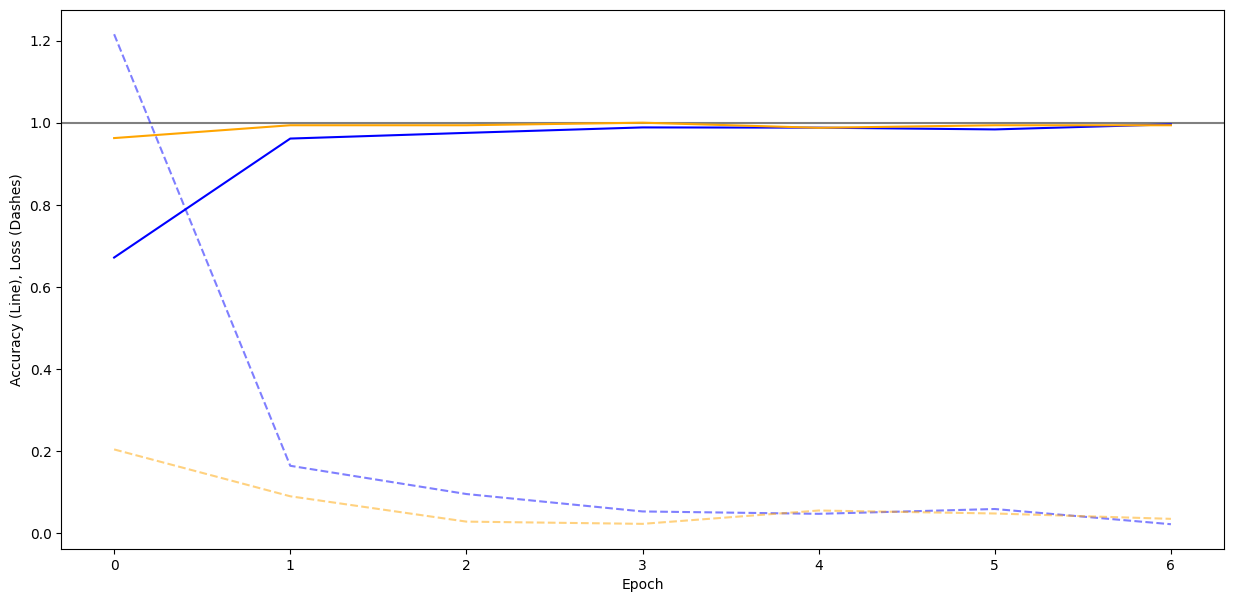

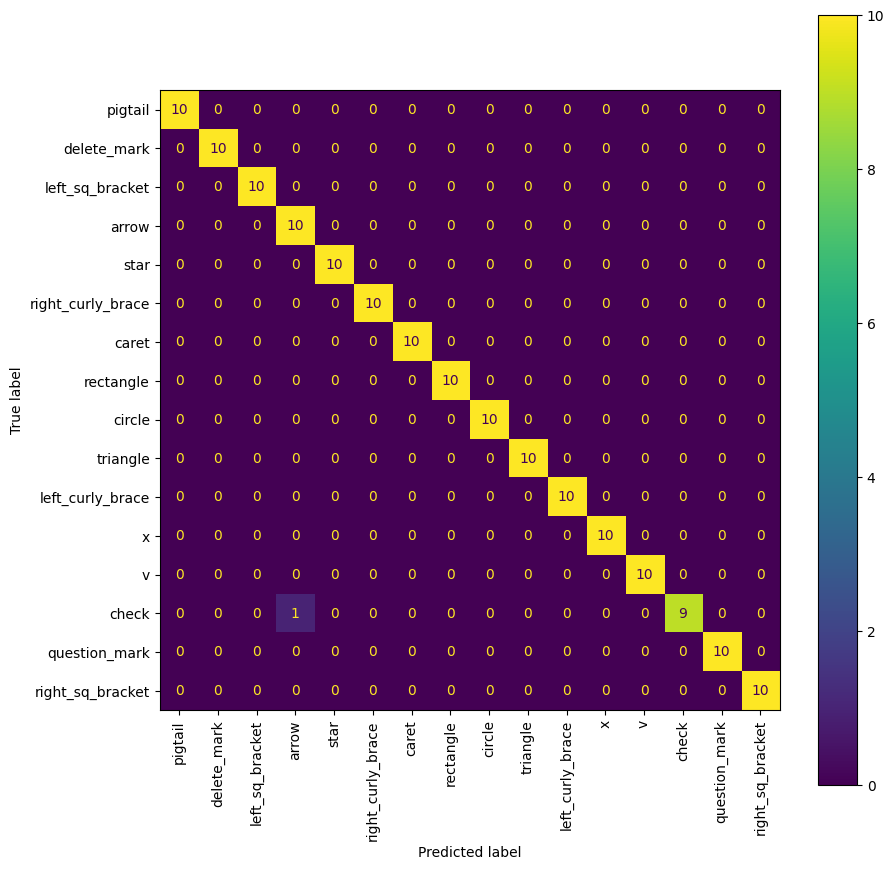

In [15]:
UNITS_LSTM = 64

model_cond2 = build_model(UNITS_LSTM)
history_cond2, duration_train_cond2 = fit_model(model_cond2)
display_summary(model_cond2)
display_results(history_cond2)
duration_predict_cond2 = predict_and_display_conf_matrix(model_cond2)
acc_cond2 = history_cond2.history['val_accuracy']

## Condition 3 - 32 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 5s 18ms/step - loss: 1.6957 - accuracy: 0.5240 - val_loss: 0.6487 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 2s 15ms/step - loss: 0.3673 - accuracy: 0.9115 - val_loss: 0.2467 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 2s 15ms/step - loss: 0.1761 - accuracy: 0.9547 - val_loss: 0.1923 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 2s 15ms/step - loss: 0.1023 - accuracy: 0.9746 - val_loss: 0.1339 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 2s 15ms/step - loss: 0.0846 - accuracy: 0.9744 - val_loss: 0.1051 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 2s 16ms/step - loss: 0.0677 - accuracy: 0.9824 - val_loss: 0.0863 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 2s 15ms/st

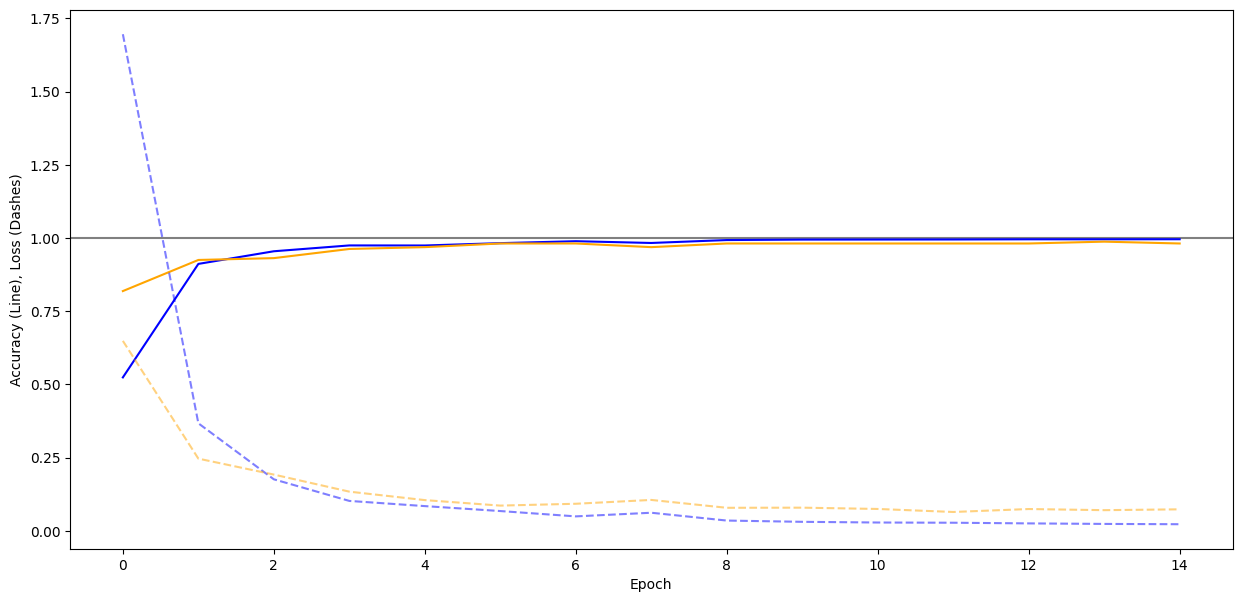

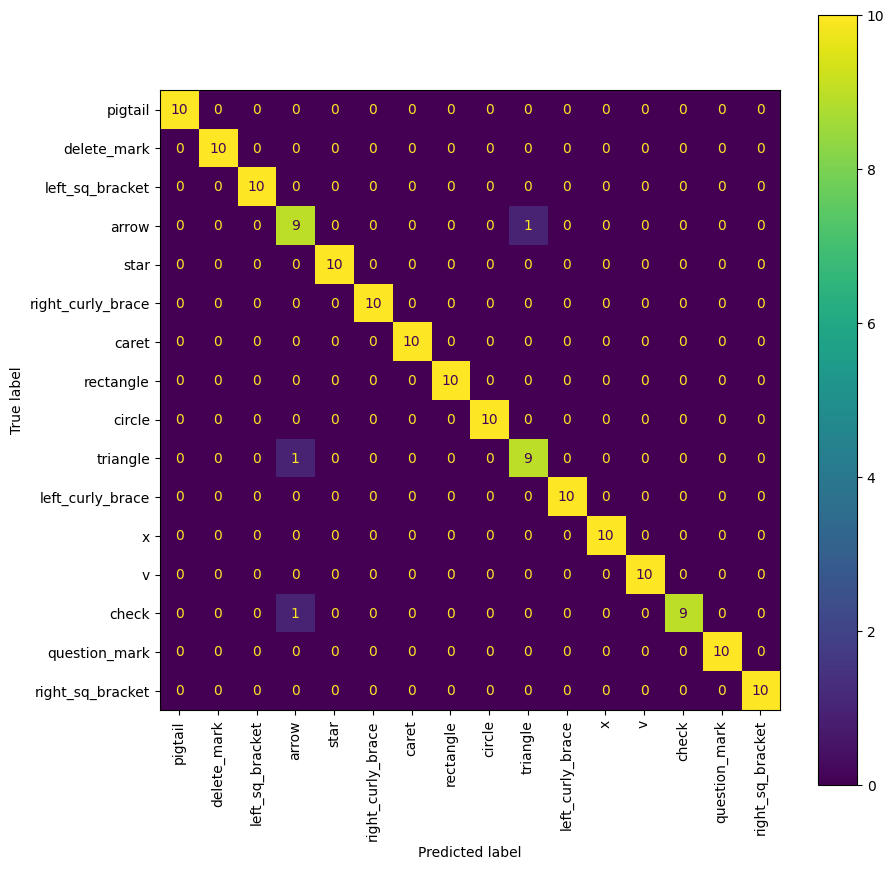

In [16]:
UNITS_LSTM = 32

model_cond3 = build_model(UNITS_LSTM)
history_cond3, duration_train_cond3 = fit_model(model_cond3)
display_summary(model_cond3)
display_results(history_cond3)
duration_predict_cond3 = predict_and_display_conf_matrix(model_cond3)
acc_cond3 = history_cond3.history['val_accuracy']

## Condition 4 - 16 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 4s 18ms/step - loss: 2.1863 - accuracy: 0.3271 - val_loss: 1.3718 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 2s 14ms/step - loss: 0.8905 - accuracy: 0.7674 - val_loss: 0.5911 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 3s 16ms/step - loss: 0.3853 - accuracy: 0.9293 - val_loss: 0.2378 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 3s 18ms/step - loss: 0.1780 - accuracy: 0.9641 - val_loss: 0.1383 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 2s 15ms/step - loss: 0.1192 - accuracy: 0.9742 - val_loss: 0.1544 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 2s 15ms/step - loss: 0.0980 - accuracy: 0.9770 - val_loss: 0.1171 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 2s 15ms/st

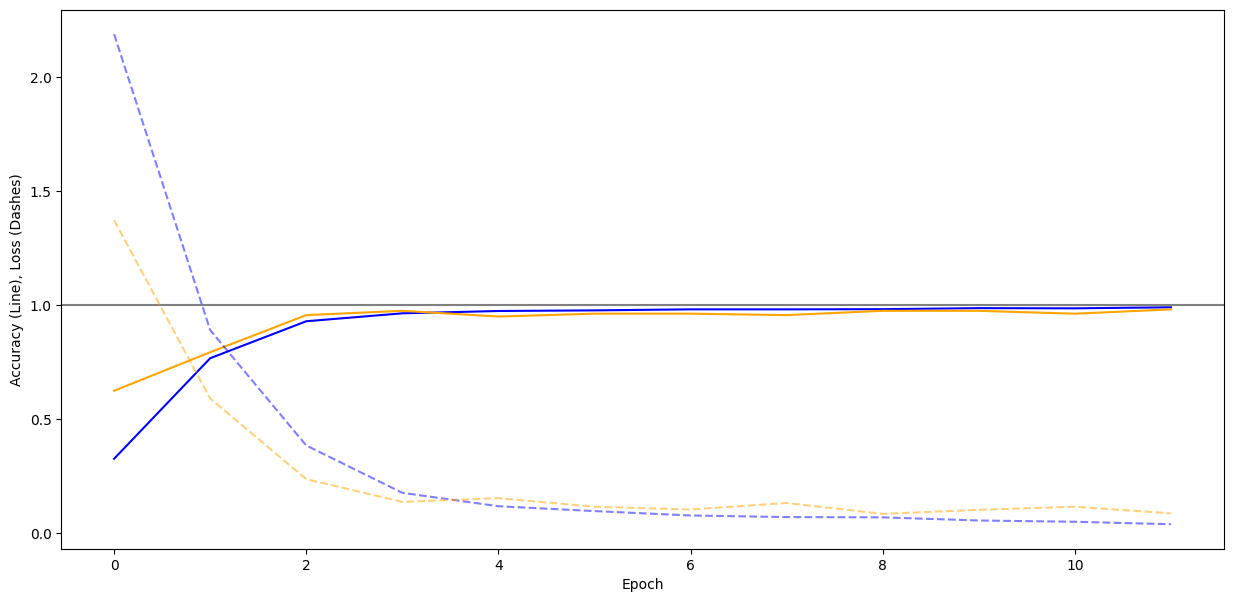

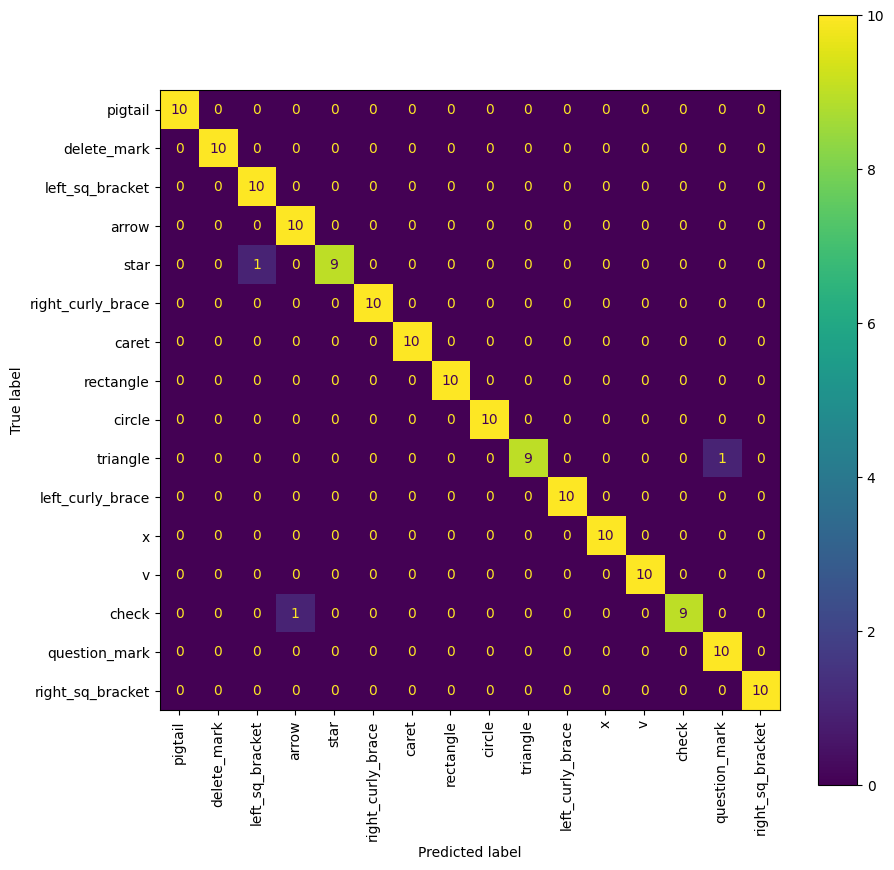

In [17]:
UNITS_LSTM = 16

model_cond4 = build_model(UNITS_LSTM)
history_cond4, duration_train_cond4 = fit_model(model_cond4)
display_summary(model_cond4)
display_results(history_cond4)
duration_predict_cond4 = predict_and_display_conf_matrix(model_cond4)
acc_cond4 = history_cond4.history['val_accuracy']

## Condition 5 - $1 Gesture Recognizer

In [28]:
from recognizer import OneDollarRecognizer

recognizer = OneDollarRecognizer(gestures, NUM_POINTS)

In [ ]:
start_predict_dollar = time.time()
y_predictions = []
for i, points in enumerate(X_test):
    gesture, score = recognizer.recognize(points)
    # points = recognizer.rotate(points)
    # gesture, score = recognizer.recognize_without_preprocessing(points)
    y_predictions.append(gesture)

duration_predict_dollar = time.time() - start_predict_dollar

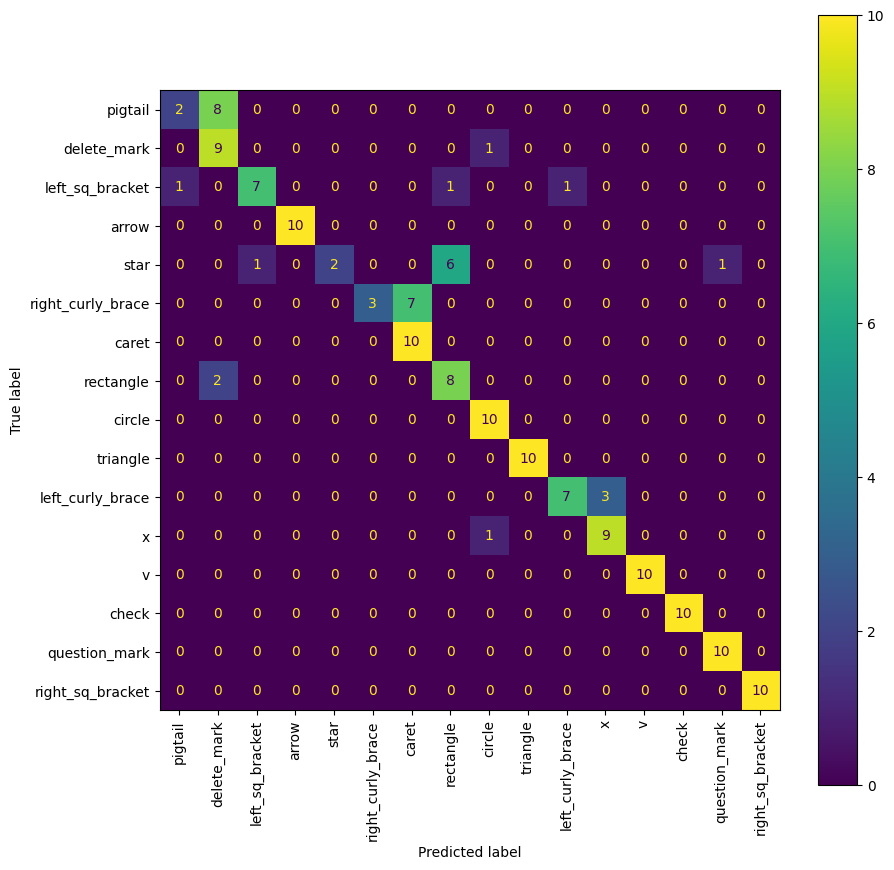

In [30]:
y_test_labels = np.argmax(y_test, axis=1)
y_test_labels = encoder_test.inverse_transform(y_test_labels)
conf_matrix = confusion_matrix(y_test_labels, y_predictions)
acc_dollar = sum(1 for predict, test in zip(y_predictions, y_test_labels) if predict == test) / len(y_predictions)

fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_test)).plot(ax=plt.gca())
plt.xticks(rotation=90, ha='center')
pass

## Comparing Results

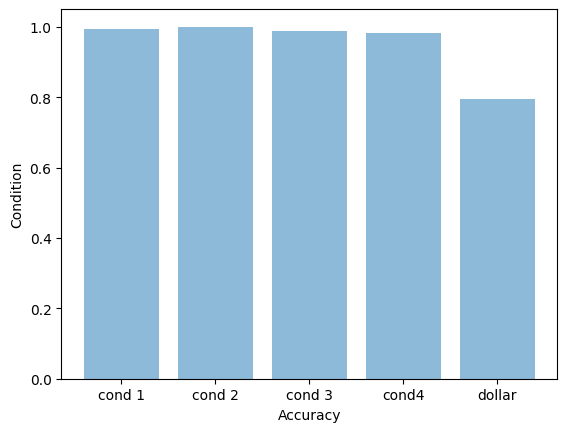

0.9937499761581421 1.0 0.987500011920929 0.981249988079071 0.79375


In [31]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4', 'dollar')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [max(acc_cond1), max(acc_cond2), max(acc_cond3), max(acc_cond4), acc_dollar], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Accuracy')

plt.show()
print(max(acc_cond1), max(acc_cond2), max(acc_cond3), max(acc_cond4), acc_dollar)

In a first step, we compare the accuracy of the gesture recognizers.
The LSTMs all provide good accuracies. Nevertheless, the 16-unit LSTM achieves slighty less accuracy.
With an accuracy of ~80%, the $1 recognizer is noticeably worse, but still ok.
This is also shown in the confusion matrices above.

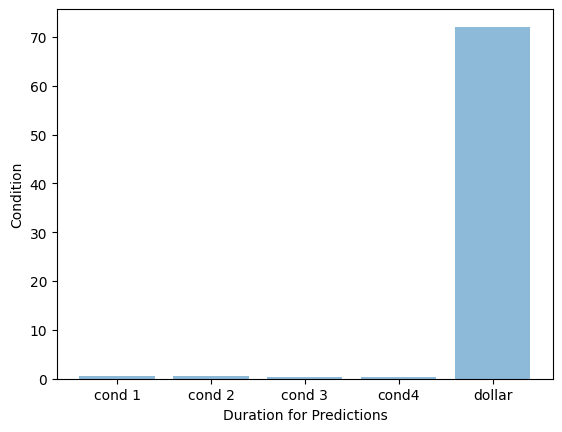

0.5690200328826904 0.49140167236328125 0.43036770820617676 0.4022789001464844 72.08076310157776


In [32]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4', 'dollar')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4, duration_predict_dollar], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Predictions')

plt.show()
print(duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4, duration_predict_dollar)

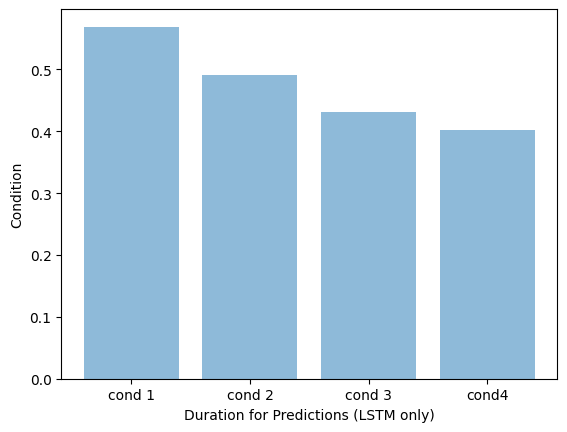

0.5690200328826904 0.49140167236328125 0.43036770820617676 0.4022789001464844


In [33]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Predictions (LSTM only)')

plt.show()
print(duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4)

When comparing the prediction time for the test data set, we observe a significant longer prediction time with the $1.
But note that there is (again) preprocessing of the test data inclueded to make sure the preprocessing of the baseline and input is the same. Nevertheless, without further preprocessing (only rotating which isn't done for test data here) it also takes noticeable longer time than LSTM predictions.    

Between the LSTM recognizers, there is a minor difference from ~160ms from slowest to fastest in prediction time - it is getting faster with less units. That makes sense. :)

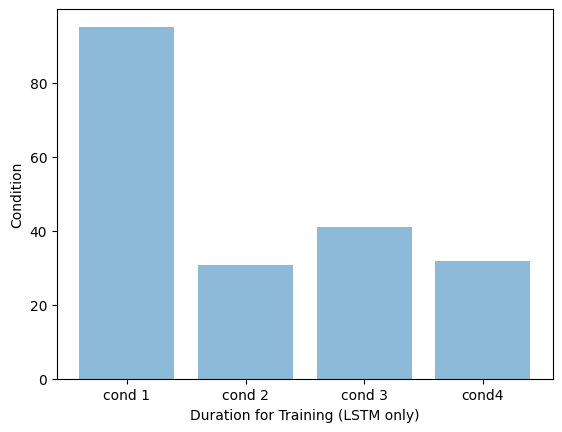

95.09052991867065 30.65604257583618 41.028374910354614 31.908156394958496


In [34]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_train_cond1, duration_train_cond2, duration_train_cond3, duration_train_cond4], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Training (LSTM only)')

plt.show()
print(duration_train_cond1, duration_train_cond2, duration_train_cond3, duration_train_cond4)

For the training time, the 128-units LSTM takes significantly more time than the other ones.
The fastest training time could be established with 64 units in the LSTM layer. The $1 recognizer is not listed here, since there is no training required. The time expenditure is limited to reading in an preprocessing data which also was done for the LSTM recognizers.

# Conslusion
For practical application, I would choose the 32-unit LSTM. It has the best accuracy and fast prediction time. 
It does not require an additional step to rotate the input which saves a bit time in predictions compared to the one-dollar recognizer. 

However, a LSTM requires a huge amount of training data whereas the one-dollar recognizer gets along without. There simply has to be one baseline for each gesture, which allows a very fast "training". Furthermore, preprocessing (besides rotating) was done with and without using a LSTM, so depending on the need of accurate predictions and the availability of train data, the $1 recognizer might be sufficient as well.